# Logistic Regression with a Neural Network
日期:2017/11/12

這是一個如何用numpy來建立一個簡單無隱藏層的Neural Network範例。



# 1. 資料處理

使用keras的圖像資料庫:

In [1]:
import numpy as np
#透過keras讀取資料
from keras.datasets import cifar10
import matplotlib.pyplot as plt
# load (downloaded if needed) the MNIST dataset
(trainData, trainTag), (testData, testTag) = cifar10.load_data()

Using TensorFlow backend.


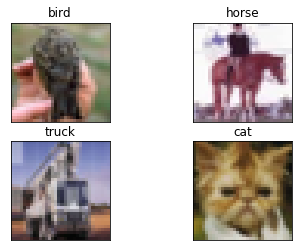

In [2]:
# 標籤名稱
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
# 繪圖
num = 2
randomIndex = np.random.choice(range(len(trainData)),num**2,replace=False)
for i in range(len(randomIndex)):
    plt.subplot(num,num,i+1,xticks=[], yticks=[])
    plt.imshow(trainData[randomIndex[i]])
    plt.title(class_names[int(trainTag[randomIndex[i]])])

plt.show()

In [3]:
#選取cat圖片
cat_index = list()
not_cat_index = list()
for i in range(trainData.shape[0]):
    if class_names[int(trainTag[i])] == 'cat':
        cat_index.append(i)
    else:
        not_cat_index.append(i)

在keras的cifar10資料庫中，training data一共有50000張圖片，其中tag分類有10種。由於我們使用Logistic Regression，training data的response需為二元分類，因此在trainData中選擇5000張貓(cat)圖片及隨機選取5000張不是貓的(not cat)圖片來做訓練；testing data從testData隨機選取2000筆。

In [4]:
#抽取5000筆非cat的圖片
random_not_cat_index = np.random.choice(not_cat_index,5000, replace=False)
train_index = np.random.choice(np.concatenate((np.array(cat_index),random_not_cat_index)),10000, replace=False)

#建立需要的訓練資料
#training data
X_train = list()
y_train_name = list()
y_train = list()
for index in train_index:
    X_train.append(trainData[index])
    if class_names[int(trainTag[index])] == 'cat':
        y_train_name.append("It's a cat.")
        y_train.append(1)
    else:
        y_train_name.append("It's not a cat.")
        y_train.append(0)

x_train = np.array(X_train)
y_train = np.array([y_train],dtype=float)

#testing data
test_index = np.random.choice(range(len(testData)),2000, replace=False)
X_test = list()
y_test_name = list()
y_test = list()
for index in test_index:
    X_test.append(testData[index])
    if class_names[int(testTag[index])] == 'cat':
        y_test_name.append("It's a cat.")
        y_test.append(1)
    else:
        y_test_name.append("It's not a cat.")
        y_test.append(0)
        
x_test = np.array(X_test)
y_test = np.array([y_test],dtype=float)

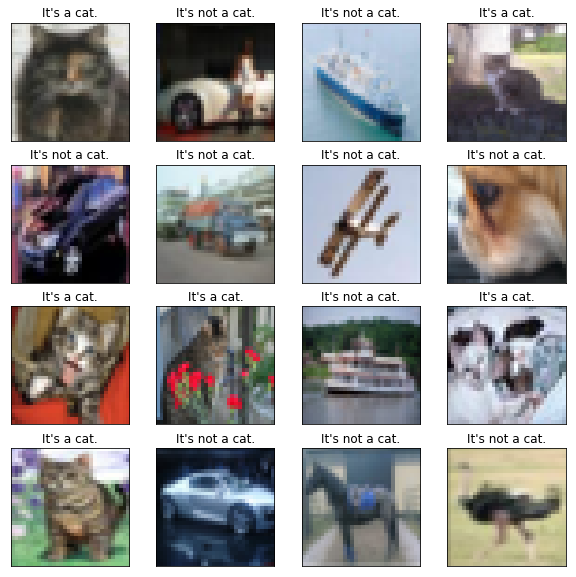

In [5]:
# check
#Visualizing CIFAR 10
num = 4
fig, axes1 = plt.subplots(num,num,figsize=(10,10))  

for i in range(num**2):
    j = np.random.choice(range(len(x_train)))
    plt.subplot(num, num, i+1,xticks=[], yticks=[])
    plt.title(y_train_name[j])
    plt.imshow(X_train[j:j+1][0])
    
plt.show()

# 2. 訓練集的調整

接下來要調整每個訓練變數的維度(或是shape)，其中在numpy的np.array()才能呼叫shape這個函式。

In [6]:
#檢視維度
m_train = x_train.shape[0]
m_test = x_test.shape[0]
num_px = x_train.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("x_train shape: " + str(x_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("x_test shape: " + str(x_test.shape))
print ("y_test shape: " + str(y_test.shape))

Number of training examples: m_train = 10000
Number of testing examples: m_test = 2000
Height/Width of each image: num_px = 32
Each image is of size: (32, 32, 3)
x_train shape: (10000, 32, 32, 3)
y_train shape: (1, 10000)
x_test shape: (2000, 32, 32, 3)
y_test shape: (1, 2000)


在x_train及x_test的shape有4個維度，為了方便輸入我們的network，必須調整訓練集及測試集的shape至2個維度。每張圖片的shape為(32,32,3)，即每張圖有32$\times$32$\times$3=3072的pixel，這時我們可以把shape轉換至(3072, 1)。<br />

在python語法中，reshape可以轉換np.array的維度。若X.shape=($a$,$b$,$c$,$d$)，則X.reshape($a$,-1)=($a$,$b\times c\times d$)。

In [7]:
# 調整訓練集及測試集的shape
x_train_flatten = x_train.reshape(x_train.shape[0],-1).T
y_train_set = y_train
x_test_flatten = x_test.reshape(x_test.shape[0],-1).T
y_test_set = y_test

print ("x_train_flatten shape: " + str(x_train_flatten.shape))
print ("y_train_set shape: " + str(y_train_set.shape))
print ("x_test_flatten shape: " + str(x_test_flatten.shape))
print ("y_test_set shape: " + str(y_test_set.shape))

x_train_flatten shape: (3072, 10000)
y_train_set shape: (1, 10000)
x_test_flatten shape: (3072, 2000)
y_test_set shape: (1, 2000)


In [8]:
x_train_set = x_train_flatten/255
x_test_set = x_test_flatten/255

圖片是由三張紅、綠、藍(red,green,blue channels -- RGB)三色的pixel所組成，每個pixel數值介於0~255之間，在machine learning與neural network最常把訓練資料數值center或是standardize，因此可以把x_train_flatten和x_test_flatten均除上255。

# 3. 無隱藏層的Simple Neural Network

# 3-1 Sigmoid functions 及初始化參數

為了要識別圖片裡面的物體是否為貓，我們開始建構我們的簡單的神經網路吧!

<img src="Pictures/simpleNN2.png" style="width:650px;height:400px;">

首先我們要建立一個無隱藏層(hidden layer)的神經網路，只有輸入層(input layer)和輸出層(output layer)。輸入層輸入X已轉成shape為(3072,1)向量、初始化的W(Weight)及b(Bias)。

對於一個樣本 $x^{(i)}$，$i=1,2,...,m$ :
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 

為了要觀察預測值與實際值的差異，會定義平方差損失函數(cost function with mean square error): 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  (y^{(i)}-a^{(i)})^{2} \tag{3}$$

不過我們是使用Logistic Regression，因此定義下列損失函數:
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{4}$$

這個損失函數合理的原因，在於當$a^{(i)}$越接近$y^{(i)}$時，$\mathcal{L}$的值會越接近0。最後整體訓練集的cost做加總平均為$J$ :

$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{5}$$

在輸出層會有一個$\sigma$為一激發函數(activation function) sigmoid function，用來把數值轉成0~1之間，輸出結果可以把它視為機率。

sigmoid function的方程式為:$sigmoid(z) = \frac{1}{1 + e^{-z}}$

sigmoid([-2,0,2]) = [ 0.11920292  0.5         0.88079708]


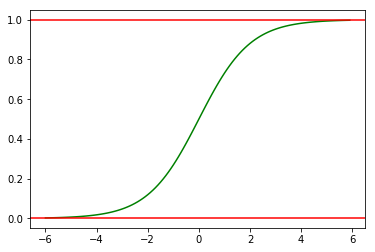

In [9]:
#定義sigmoid function
def sigmoid(z):
    return 1/(1+np.exp(-z))

print("sigmoid([-2,0,2]) = " + str(sigmoid(np.array([-2,0,2]))))
#繪製sigmoid function
x = np.arange(-6.0, 6.0, 0.1)
plt.plot(x,sigmoid(x),color='green')
plt.axhline(0,color='red')
plt.axhline(1,color='red')
plt.show()

In [10]:
#initialize W and b
def simple_initialize_zero(dim):
    w = np.zeros((dim,1))
    b = 0
    return w,b

w, b = simple_initialize_zero(3072)
print("w = " + str(w))
print("b = " + str(b))

w = [[ 0.]
 [ 0.]
 [ 0.]
 ..., 
 [ 0.]
 [ 0.]
 [ 0.]]
b = 0


# 3-2 Forward 及 Backward propagation

在內神經的傳導中會分成Forward propagation及Backward propagation，Forward propagation是傳導從輸入層道輸出層，步驟中如上述方程式(1)~(5)式；Backward propagation是從輸出層傳遞至輸入層來更新層與層之間的參數，這裡需要透過微積分的chain rule來計算。propagation為波的傳播，相當於一步步計算神經裡面的數學結構。

Backward propagation的詳細推導如下:
<img src="Pictures/Backward1.jpg" style="width:650px;height:400px;">


計算dw及db:
$$ \frac{\partial J}{\partial w} = \frac{1}{m}\sum_{i=1}^m\frac{\partial \mathcal{L}(a^{(i)}, y^{(i)})}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{6}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m}\sum_{i=1}^m\frac{\partial \mathcal{L}(a^{(i)}, y^{(i)})}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{7}$$


In [11]:
#定義波的傳播方程式
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    # forward propagate
    A = sigmoid(np.dot(w.T,X))
    cost = -np.sum(np.dot(Y,np.log(A).T)+np.dot((1-Y),np.log(1-A).T))/m   
    
    # backward propagate
    dw = np.dot(X,(A-Y).T)/m
    db = np.sum((A-Y).T)/m
    
    cost = np.squeeze(cost)
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

# 3-3 選擇測試函數

為了要更新w及b，需要定義測試函數(Optimization Test functions)來更新，本例為使用梯度下降法(Gradient descent)，其公式如下:

$$ w_{i+1} = w_{i} - \alpha \frac{\partial J(w)}{\partial w_{i}} \tag{8}$$  

其中$\alpha$為學習率(learning rate)，來控制每一步的大小，$\alpha$越大則走越快，反之則越慢。
測試函數也有其他方法可以使用，之後再詳細介紹。

In [12]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = list()
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        dw = grads['dw']
        db = grads['db']
        
        # 更新w和b
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # 紀錄costs
        if i % 100 == 0:
            costs.append(cost)
        
        # 每迭代100次顯示一次
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
        params = {"w": w,"b": b}
        grads = {"dw": dw,"db": db}
    
    return params, grads, costs

# 3-4 預測

經過激發函數後會得到一機率值，在本例中，當$y^{(i)}>0.5$時，代表該張圖為"It's a cat."，反之為"It's not a cat."。

In [13]:
def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T,X)+b)

    for i in range(A.shape[1]):
        if A[0,i] > 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0

    return Y_prediction

# 3-5 定義模型並訓練

定義好前面的function後，把它們放在我們定義好的模型中。

In [16]:
# 定義模型
def model(Xtrain, Ytrain, Xtest, Ytest, num_iterations, learning_rate , print_cost = False):
   
    # initialize parameters w and b
    w, b = simple_initialize_zero(Xtrain.shape[0])

    # Gradient descent 
    parameters, grads, costs = optimize(w, b, Xtrain, Ytrain, num_iterations, learning_rate, print_cost = print_cost)
    w = parameters["w"]
    b = parameters["b"]
    
    # 預測test/train set 
    Y_prediction_test = predict(w, b, Xtest)
    Y_prediction_train = predict(w, b, Xtrain)

    # 顯示train/test誤差
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Ytrain)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Ytest)) * 100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [17]:
model_fit = model(Xtrain = x_train_set, Ytrain = y_train_set, Xtest = x_test_set, Ytest = y_test_set, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.641907
Cost after iteration 200: 0.630366
Cost after iteration 300: 0.623489
Cost after iteration 400: 0.618683
Cost after iteration 500: 0.615064
Cost after iteration 600: 0.612220
Cost after iteration 700: 0.609919
Cost after iteration 800: 0.608017
Cost after iteration 900: 0.606417
Cost after iteration 1000: 0.605049
Cost after iteration 1100: 0.603863
Cost after iteration 1200: 0.602822
Cost after iteration 1300: 0.601898
Cost after iteration 1400: 0.601070
Cost after iteration 1500: 0.600320
Cost after iteration 1600: 0.599636
Cost after iteration 1700: 0.599007
Cost after iteration 1800: 0.598424
Cost after iteration 1900: 0.597881
train accuracy: 68.45 %
test accuracy: 67.3 %


train accuracy和test accuracy分別為訓練和測試資料集之準確率，若train accuracy遠大於test accuracy時，代表模型有overfitting的現象，這時需調整你的神經網路的參數或是架構了。而本訓練結果在train accuracy與test accuracy接近7成的準確率，在簡單的神經網路還算可以的。

接下來從測試集中選取一些圖片來做預測:

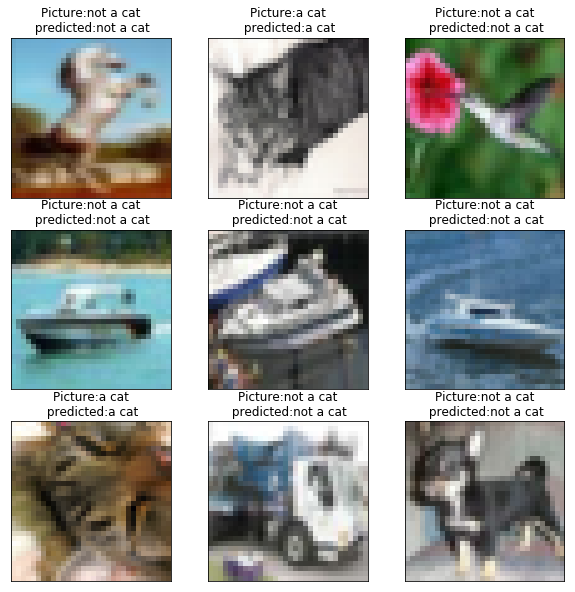

In [96]:
# 從測試集隨機選取9張圖片做預測
num = 3
fig, axes1 = plt.subplots(num,num,figsize=(10,10))  

for i in range(num**2):
    j = np.random.choice(range(x_test_set.shape[1]))
    if model_fit["Y_prediction_test"][0,j] == 1:
        result = "a cat" 
    else:
        result = "not a cat" 
    if y_test_set[0,j] == 1:
        real = "a cat" 
    else:
        real = "not a cat" 
        
    plt.subplot(num, num, i+1,xticks=[], yticks=[])
    plt.title("Picture:" + real + "\n predicted:" + result)
    plt.imshow(x_test_set[:,j].reshape((num_px, num_px, 3)))
    
plt.show()

# Reference
類神經網路 -- Backward Propagation 詳細推導過程 http://cpmarkchang.logdown.com/posts/277349-neural-network-backward-propagation<br />
史丹佛大學機器學習（Machine Learning）上課筆記（一） https://blog.gtwang.org/statistics/standford-machine-learning-1/ <br />
coursera課程 https://www.coursera.org/